In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import math

base_path = "/content/drive/MyDrive/CIC-IDS/CIC-IDS-2017/Dataset/CIC-IDS-2017/CSVs/MachineLearningCSV/MachineLearningCVE"

csv_files = [
    "Monday-WorkingHours.pcap_ISCX.csv",
    "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday-workingHours.pcap_ISCX.csv",
    "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
]

dfs = [pd.read_csv(os.path.join(base_path, f)) for f in csv_files]
data = pd.concat(dfs, ignore_index=True)
data.columns = data.columns.str.strip()

data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

def map_label(l):
    l = str(l).strip()
    if l == "BENIGN": return "Benign"
    if "DoS" in l or "DDoS" in l: return "DoS/DDoS"
    if "PortScan" in l: return "PortScan"
    if "Patator" in l or "Brute Force" in l: return "Brute Force"
    if "Web Attack" in l: return "Web Attacks"
    return None

data["Class"] = data["Label"].apply(map_label)
data = data[data["Class"].notna()]

print("Labels mapped:", data["Class"].value_counts())

MAX_SAMPLES_PER_CLASS = 60000

sampled_data = []

for cls in data["Class"].unique():
    df_cls = data[data["Class"] == cls]

    if len(df_cls) > MAX_SAMPLES_PER_CLASS:
        df_cls = df_cls.sample(MAX_SAMPLES_PER_CLASS, random_state=42)

    sampled_data.append(df_cls)

data = pd.concat(sampled_data, ignore_index=True)

print("After balanced sampling:", data.shape)
print(data["Class"].value_counts())

cols_to_drop = ["Label", "Timestamp", "Flow ID", "Source IP",
                "Destination IP", "Source Port", "Destination Port", "Protocol"]

for c in cols_to_drop:
    if c in data.columns:
        data = data.drop(columns=[c])

X = data.select_dtypes(include=["float64", "int64"])
y = data["Class"]

X = X.replace([np.inf, -np.inf], np.nan)
mask = X.notna().all(axis=1)
X = X[mask]
y = y[mask]

le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_enc, test_size=0.30, random_state=42, stratify=y_enc
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Standardized shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)

Labels mapped: Class
Benign         2271320
DoS/DDoS        379737
PortScan        158804
Brute Force      15339
Web Attacks        673
Name: count, dtype: int64
After balanced sampling: (196012, 80)
Class
Benign         60000
DoS/DDoS       60000
PortScan       60000
Brute Force    15339
Web Attacks      673
Name: count, dtype: int64
Standardized shapes: (137208, 77) (29402, 77) (29402, 77)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = 5
knn = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)
knn.fit(X_train_s, y_train)

knn_train_proba = knn.predict_proba(X_train_s)
knn_val_proba   = knn.predict_proba(X_val_s)
knn_test_proba  = knn.predict_proba(X_test_s)

print("KNN proba shapes:", knn_train_proba.shape, knn_val_proba.shape, knn_test_proba.shape)

X_train_knn = np.concatenate([X_train_s, knn_train_proba], axis=1)
X_val_knn   = np.concatenate([X_val_s,   knn_val_proba],   axis=1)
X_test_knn  = np.concatenate([X_test_s,  knn_test_proba],  axis=1)

input_dim_knn = X_train_knn.shape[1]
num_classes   = len(le.classes_)

print("KNN hybrid shapes:")
print("Train:", X_train_knn.shape)
print("Val:  ", X_val_knn.shape)
print("Test: ", X_test_knn.shape)
print("Input dim knn:", input_dim_knn)

KNN proba shapes: (137208, 5) (29402, 5) (29402, 5)
KNN hybrid shapes:
Train: (137208, 82)
Val:   (29402, 82)
Test:  (29402, 82)
Input dim knn: 82


In [ ]:
def build_cldnn(input_dim, num_classes):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(), layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(), layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_1d_cnn(input_dim, num_classes):
    m = models.Sequential([
        layers.Reshape((input_dim, 1)),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 3, activation='relu'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_cnn(input_dim, num_classes):
    side = int(math.ceil(math.sqrt(input_dim)))
    pad = side*side - input_dim
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Lambda(lambda x: tf.pad(x, [[0,0],[0,pad]])),
        layers.Reshape((side, side, 1)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_cnn_lstm(input_dim, num_classes):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Reshape((input_dim, 1)),
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.LSTM(64),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

def build_mlp(input_dim, num_classes):
    m = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    m.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return m

In [ ]:
def run(model, name, X_tr, X_v, X_te):
    print(f"\n===== {name} =====")
    history = model.fit(
        X_tr, y_train,
        validation_data=(X_v, y_val),
        epochs=5,
        batch_size=64,
        verbose=1
    )

    val_acc  = history.history["val_accuracy"][-1]
    val_loss = history.history["val_loss"][-1]
    print(f"Validation Accuracy: {val_acc:.6f}")
    print(f"Validation Loss:     {val_loss:.6f}")

    loss, acc = model.evaluate(X_te, y_test, verbose=0)
    print(f"Test Accuracy:       {acc:.6f}")
    print(f"Test Loss:           {loss:.6f}")

    preds = model.predict(X_te).argmax(axis=1)

    print(classification_report(
        y_test,
        preds,
        target_names=le.classes_,
        digits=6
    ))
    print("Confusion:\n", confusion_matrix(y_test, preds))

    return history, preds, acc

In [ ]:
accuracies = []
model_names = []

cldnn_knn = build_cldnn(input_dim_knn, num_classes)
hist_knn_cldnn, preds_knn_cldnn, acc_knn_cldnn = run(
    cldnn_knn, "KNN + ClDNN",
    X_train_knn, X_val_knn, X_test_knn
)
accuracies.append(acc_knn_cldnn); model_names.append("KNN + ClDNN")

cnn1d_knn = build_1d_cnn(input_dim_knn, num_classes)
hist_knn_1dcnn, preds_knn_1dcnn, acc_knn_1dcnn = run(
    cnn1d_knn, "KNN + 1D-CNN",
    X_train_knn, X_val_knn, X_test_knn
)
accuracies.append(acc_knn_1dcnn); model_names.append("KNN + 1D-CNN")

cnn_knn = build_cnn(input_dim_knn, num_classes)
hist_knn_cnn, preds_knn_cnn, acc_knn_cnn = run(
    cnn_knn, "KNN + CNN",
    X_train_knn, X_val_knn, X_test_knn
)
accuracies.append(acc_knn_cnn); model_names.append("KNN + CNN")

mlp_knn = build_mlp(input_dim_knn, num_classes)
hist_knn_mlp, preds_knn_mlp, acc_knn_mlp = run(
    mlp_knn, "KNN + MLP",
    X_train_knn, X_val_knn, X_test_knn
)
accuracies.append(acc_knn_mlp); model_names.append("KNN + MLP")

cnnlstm_knn = build_cnn_lstm(input_dim_knn, num_classes)
hist_knn_cnnlstm, preds_knn_cnnlstm, acc_knn_cnnlstm = run(
    cnnlstm_knn, "KNN + CNN-LSTM",
    X_train_knn, X_val_knn, X_test_knn
)
accuracies.append(acc_knn_cnnlstm); model_names.append("KNN + CNN-LSTM")


===== KNN + ClDNN =====
Epoch 1/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9681 - loss: 0.0968 - val_accuracy: 0.9900 - val_loss: 0.0339
Epoch 2/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9927 - loss: 0.0220 - val_accuracy: 0.9912 - val_loss: 0.0303
Epoch 3/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9935 - loss: 0.0195 - val_accuracy: 0.9912 - val_loss: 0.0334
Epoch 4/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9932 - loss: 0.0184 - val_accuracy: 0.9923 - val_loss: 0.0355
Epoch 5/5
2144/2144 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9941 - loss: 0.0177 - val_accuracy: 0.9913 - val_loss: 0.0300
Validation Accuracy: 0.991293
Validation Loss:     0.030024
Test Accuracy:       0.990137
Test Loss:           5.204165
919/919 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
              precision    recall  f1-score   support

      Benign   0.990143  0.993333  0.991736      9000
 Brute Force   0.976965  0.940026  0.958140      2301
    D

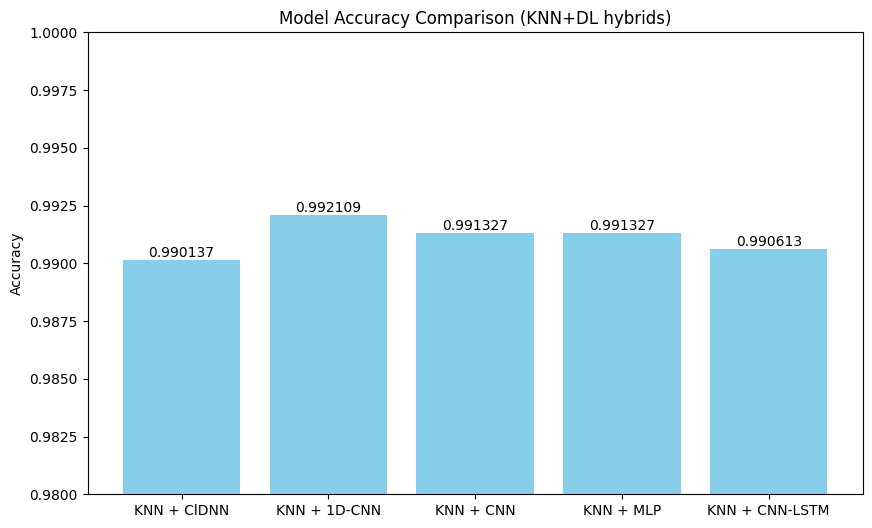

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(model_names, accuracies, color='skyblue')
plt.ylim(0.980, 1.0)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (KNN+DL hybrids)")

for i, acc in enumerate(accuracies):
    plt.text(i, acc, f"{acc:.6f}", ha='center', va='bottom')

plt.show()